## This script is used to compare two different indices that are used to quantify aggregation 
 - the mesoscale total water path variance ratio 
 
   - what variable do I need to compute this? (TWP)
     TWP: vertically integrated moisture (vapor + liquid water), this is a 2D quantity
     I need the block average TWP as well, so in which dataset can I find this?
     
      - potentially in OUT_2D/*MSE*.nc: Peter noted that some of the water path computations had a bug.. (which ones?)
        If I need to compute the TWP, I need to compute it by vertically integrating QTOT in OUT_3D/*MSE*.nc
        
        - how do have get the mesoscale variance of TWP? (mesoscale block mean - domain mean)^2
          Is mesoscale block mean already available??
       
       
   
 - the SCAI (Simple Convective Aggregation Index)
 
   - a cloud mask is needed to compute this SCAI index;
   
     how can I create such mask that is similar to the OLR given by the satellite?
     
     A cloud is given by q_c >0.01 g/kg  (QCL in the OUT_3D/*.nc)
     since QCL is a 3D variable, do I need to project this to a plane? 
     perhaps I can count to check if there is cloud whenever q_c > 0.01 g/kg exist (in any one level in the model.)
     
   - also need the regionprops function (I can make use of Janssens's python code)
 
  

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 
from scipy import interpolate

In [2]:
# specify the data path:
datadir = '/data/xchen/BB2017'

# Task #2: check the "aggregation indices"
folder1 = 'OUT_2D/S6_MSE'    
folder2 = 'OUT_3D'    # 

file_prefix = 'S6_CTL_MSE_512sqx128_250m_testf'

file_suffix_3D = '_0128_CONCAT.nc'
file_suffix_2D = '_0128.2Dbin_1.nc'



In [3]:
case_list = ['cntrl','noPCP', 'RADhomo', 'RADFLXhomo', 'RFhomoNoPCP', 'WTG']

In [4]:
# establish a dictionary to store filenames for 2D/3D experiments with differen physics:
filenames=dict()
filenames['2D']=dict()
filenames['3D']=dict()
for i, cn in enumerate(case_list):
    if cn == 'cntrl':
        filenames['2D'][cn] = file_prefix + file_suffix_2D
        filenames['3D'][cn] = file_prefix + file_suffix_3D
    else:
        filenames['2D'][cn] = file_prefix + '_' + cn + file_suffix_2D
        filenames['3D'][cn] = file_prefix + '_' + cn + file_suffix_3D
        


In [5]:
# construct path to data:
case_label = 'cntrl'
path_to_2Ddata = os.path.join(datadir, folder1, filenames['2D'][case_label])
ds_2D = xr.open_dataset(path_to_2Ddata)

path_to_3Ddata = os.path.join(datadir, folder2, filenames['3D'][case_label])
ds_3D = xr.open_dataset(path_to_3Ddata)

In [34]:
dz = np.diff(ds_3D.z)

In [6]:
ds_3D

<xarray.Dataset>
Dimensions:   (time: 432, x: 32, y: 32, z: 128)
Coordinates:
  * x         (x) float32 0.0 4e+03 8e+03 1.2e+04 ... 1.16e+05 1.2e+05 1.24e+05
  * y         (y) float32 0.0 4e+03 8e+03 1.2e+04 ... 1.16e+05 1.2e+05 1.24e+05
  * z         (z) float32 40.0 120.0 200.0 ... 1.812e+04 1.884e+04 1.961e+04
  * time      (time) float32 196.0 196.0 196.0 196.0 ... 199.0 199.0 199.0 199.0
Data variables: (12/67)
    p         (z) float32 ...
    U         (time, z, y, x) float32 ...
    V         (time, z, y, x) float32 ...
    W         (time, z, y, x) float32 ...
    TABS      (time, z, y, x) float32 ...
    TVPRIME   (time, z, y, x) float32 ...
    ...        ...
    WSTOR     (time, z, y, x) float32 ...
    WEDDY     (time, z, y, x) float32 ...
    WLSF      (time, z, y, x) float32 ...
    WMISC     (time, z, y, x) float32 ...
    WPGRAD    (time, z, y, x) float32 ...
    WBUOY     (time, z, y, x) float32 ...
Attributes:
    history:                   Sat Jun 10 21:58:00 2017: ncrcat -o S6_CTL_MSE...
    nco_openmp_thread_number:  1

In [37]:
# now read TWP from one of the experiment:

# compute the meoscale total water path variance ratio:
def compute_TWP_mesoscale_VarRatio(TWP, TWP_blockave):
    """
    This function compute the mesoscale TWP variance ratio;
    TWP_blockave is the block averged (16km^2) TWP.
    shape of the TWP matirx: [NX, NY, NT]
    """
    [NX, NY, NT] = np.shape(TWP)
    
    # computing block-averaged TWP 
    
    
    # initialize:
    TWP_var = np.zeros(np.shape(TWP))
    TWP_mvar = TWP_var
    TWPm_VarRatio = TWP_var
    
    for it in range(NT):
        TWP_var[:,:,it] = np.var(TWP[:,:,it])
        TWP_mvar[:,:,it] = (TWP_blockave[:,:,it] - np.mean(TWP[:,:,it]))**2/ (NX*NY)
        
    TWPm_VarRatio = TWP_mvar / TWP_var
    
    return TWPm_VarRatio, TWP_var, TWP_mvar
    
    
# define a function to compute the total water path: 
def compute_total_water_path(Qt, rho_a, z):
    """
    This function computes the total water path according to the following equation:
     - Wp = \int_0^{z} rho_air* Q_tot dz
       where the Q_tot is the total water mixing ratio, 
       the units of the water path is kg/m^2, consist with the units in Peter's dataset.
       
    - maybe a question to Peter: what is the appropriate density to use for this TWP integration...
    """
    integrand = rho_a * Qt
    TWP = np.trapz(integrand, z, axis=1)
    return TWP
    
# compute the SCAI index 

def compute_SCAI (cloud_mask):
    """
    Refer to Janssen's code:
    """
    SCAI = np.zeros(np.shape(cloud_mask))
    # need to develope more here
    return SCAI

In [63]:
TWP = compute_total_water_path(ds_3D.QTOT, ds_3D.RHO, ds_3D.z)

In [64]:
# compare TWP values computed from the 3D dataset and the TWP values in the 2D dataset:
TWP_peter = ds_2D.TWP.values
TWP_dif = TWP - TWP_peter

In [ ]:
# compute mesoscale ratio:
TWPm_ratio_xc = compute_TWP_mesoscale_VarRatio(TWP, TWPm)
TWPm_ratio_p = compute_TWP_mesoscale_VarRatio(TWP_peter, TWPm)

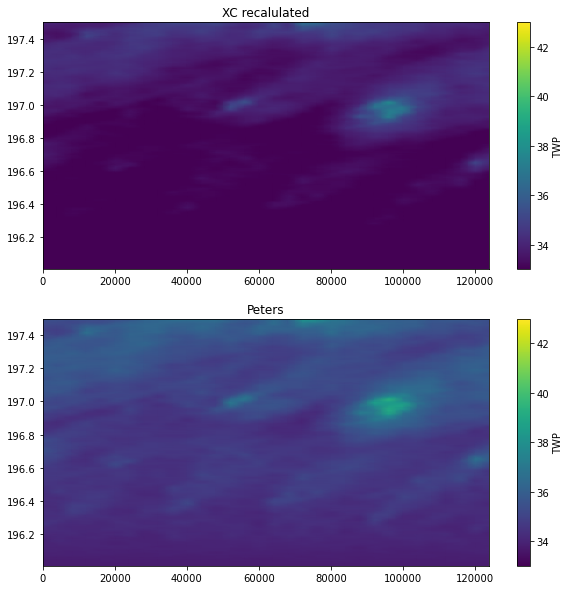

In [65]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
hm = ax[0].pcolormesh(ds_2D.x, ds_2D.time, TWP[:,:,16],shading='gouraud', vmin = 33, vmax = 43)
ax[0].set_title('XC recalulated')
hb=fig.colorbar(hm, ax=ax[0])
hb.set_label('TWP')

hm = ax[1].pcolormesh(ds_2D.x, ds_2D.time, TWP_peter[:,:,16],shading='gouraud', vmin = 33, vmax = 43)
ax[1].set_title('Peter''s')
hb = fig.colorbar(hm, ax=ax[1])
hb.set_label('TWP')


In [69]:
# compare the TWP variance:
TWP_var_xc = np.var(TWP, axis=(1,2))
TWP_var_p = np.var(TWP_peter, axis=(1,2))

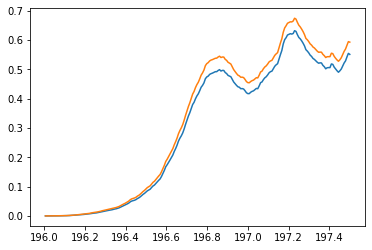

In [73]:
plt.plot(ds_3D.time, TWP_var_xc)
plt.plot(ds_2D.time, TWP_var_p)

In [ ]:
# compare the 